# POS TAGGER UNIGRAM
- Contagem de TAGS que mais aparecem, análise com sufixo das palavras para classificação de palavras desconhecidas no dataset.



## Captura de Dados | Peen Tree Bank Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

path = "/content/drive/MyDrive/O LIVRO/Penn Treebank/Penn Treebank/Secs0-18 - training"
content = []
with open(path,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content.extend(pt)

content

In [ ]:
content

## Tratamento de Dados

In [ ]:
# Reconstruindo as frases para adicionar análise de dados com BOS/EOS
sentence = []
text_sentences = []

for (word,tag) in content:
  if tag=='.':
    sentence.append((word,tag))
    text_sentences.append(sentence)
    sentence = []
  else:
    sentence.append((word,tag))

In [ ]:
text_sentences[1]

[('Mr.', 'NNP'),
 ('Vinken', 'NNP'),
 ('is', 'VBZ'),
 ('chairman', 'NN'),
 ('of', 'IN'),
 ('Elsevier', 'NNP'),
 ('N.V.', 'NNP'),
 (',', ','),
 ('the', 'DT'),
 ('Dutch', 'NNP'),
 ('publishing', 'VBG'),
 ('group', 'NN'),
 ('.', '.')]

In [ ]:
# Adicionar TAGS BOS/EOS no início e no fim de cada frase

for i in range(len(text_sentences)):
  text_sentences[i].insert(0,('<BOS>','<BOS>'))
  text_sentences[i].insert(len(text_sentences[i]),('<EOS>','<EOS>'))

In [ ]:
text_sentences[0]

[('<BOS>', '<BOS>'),
 ('Pierre', 'NNP'),
 ('Vinken', 'NNP'),
 (',', ','),
 ('61', 'CD'),
 ('years', 'NNS'),
 ('old', 'JJ'),
 (',', ','),
 ('will', 'MD'),
 ('join', 'VB'),
 ('the', 'DT'),
 ('board', 'NN'),
 ('as', 'IN'),
 ('a', 'DT'),
 ('nonexecutive', 'JJ'),
 ('director', 'NN'),
 ('Nov.', 'NNP'),
 ('29', 'CD'),
 ('.', '.'),
 ('<EOS>', '<EOS>')]

## Gerando formato Lisp-tree para usar o evalb

In [ ]:
def format_lisp_tree(sentence):
    """
    Recebe uma sentença como lista de pares (word, tag)
    Exemplo:
        sentence = [("dog", "NN"), ("barks", "VBZ"), (".", ".")]
    Retorna uma string no formato:
        (S (NN dog) (VBZ barks) (. .))
    """
    inner = " ".join([f"({tag} {word})" for (word, tag) in sentence])
    return f"(S {inner})"

In [ ]:
format_lisp_tree(text_sentences[1])

'(S (<BOS> <BOS>) (NNP Mr.) (NNP Vinken) (VBZ is) (NN chairman) (IN of) (NNP Elsevier) (NNP N.V.) (, ,) (DT the) (NNP Dutch) (VBG publishing) (NN group) (. .) (<EOS> <EOS>))'

In [ ]:
text_format_evalb = [format_lisp_tree(sentence) for sentence in text_sentences]

## Classificador: Separação de Words e Taggers

In [ ]:
# Separa taggers e words em duas listas
taggers = [tagger[1] for tagger in content]

words = [word[0] for word in content]

In [ ]:
# Cria um DataFrame para separar os dados do content
df = pd.DataFrame(content, columns=["word", "tag"])

# Contando as frequências de cada par (tag, word)
df = df.groupby(["word", "tag"]).size().reset_index(name="freq")


In [ ]:
df

## Modelo de unigrama

In [ ]:
# Para cada palavra, pegamos a tag mais frequente associada
# Vamos criar um dicionário onde a chave é a palavra e o valor é a tag mais frequente
unigram_model = {}

for word in df["word"].unique():
    # Filtramos as linhas que correspondem a esta palavra
    word_data = df[df["word"] == word]

    # Encontramos a tag com maior frequência para essa palavra
    most_frequent_tag = word_data.loc[word_data["freq"].idxmax()]["tag"]

    # Adicionamos ao modelo unigram
    unigram_model[word] = most_frequent_tag

# Exibindo o modelo unigram
print("Modelo Unigram:")
print(unigram_model)

Capturando o Test set para o treino

In [ ]:
test_set = "/content/drive/MyDrive/O LIVRO/Penn Treebank/Penn Treebank/Secs19-21 - development" #Ju

In [ ]:
content_test_set = []
with open(test_set,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content_test_set.extend(pt)

words = [word[0] for word in content_test_set]

In [ ]:
df_test = pd.DataFrame(columns=["word", "tag"])

In [ ]:
df_test["word"] = [word[0] for word in content_test_set]
df_test["tag"] = [word[1] for word in content_test_set]

In [ ]:
df_test

## UnigramTagger


*   Analisamos as palavras RARAS no dataset de treino, para retirar o sufixo e analisar a sua classificação no dataset.
*   Criamos um classificador de palavras desconhecidas apartir dessa análise



In [ ]:
import pandas as pd

list_input = list(zip(words, taggers))

#Tabela com as palavras e as tags
words_table = pd.DataFrame(list_input, columns=["word", "tag"])

#Tabela com as frequências de classificação de cada palavra, com as mais variadas classificações
words_table_freq = words_table.groupby("word").size().reset_index(name="freq")

In [ ]:
words_table_freq

In [ ]:
#Captando as palavras que aparecem 5 vezes no dataset
freq5_words = words_table_freq[words_table_freq['freq'] == 5]['word']

#juntando as palavras que aparecendo até 5 vezes no dataset com as suas tags
words_with_tags_freq5 = words_table[words_table['word'].isin(freq5_words)] #em formato de tabela

words_with_tags_freq5_list = words_with_tags_freq5['word'].unique().tolist() #apenas essas palavras raras, em lista

Extraindo padrões dos sufixos das palavras raras

In [ ]:
from collections import defaultdict

#extraindo padrões de sufixo para palavras raras
suffix_stats_5 = defaultdict(lambda: defaultdict(int))  # suffix_stats[suffix][tag] += 1

for word in words_with_tags_freq5_list:
  for k in [2, 3, 4,5]:  # pegando sufixos de 2 a 5 letras
        if len(word) >= k:
          suffix = word[-k:].lower()
          for tagg_word in words_with_tags_freq5[words_with_tags_freq5['word']== word]['tag']:
            suffix_stats_5[suffix][tagg_word] += 1 #pega o sufixo e a tag que aquela palavra foi classificada

In [ ]:
suffix_stats_2_3_4_5 = suffix_stats_5 # sufixo das palavras 'raras' que tem freq=5, e as suas respectivas classificações de TAGS

Classificador para palavras desconhecidas a partir de palavras raras

In [ ]:
suffix_stats_2_3_4_5 # sufixo das palavras 'raras' que tem freq=5, e as suas respectivas classificações de TAGS


In [ ]:
suffix_stats_2_3_4_5

In [ ]:
# Exibir os sufixos mais informativos
for suffix, tag_dict in sorted(suffix_stats_2_3_4_5.items(), key=lambda x: sum(x[1].values()), reverse=True)[:10]:
    print(f"Sufixo: {suffix}")
    for tag, count in sorted(tag_dict.items(), key=lambda x: -x[1]):
        print(f"  {tag}: {count}")

Sufixo: ed
  NN: 30
  NNP: 24
  IN: 20
  DT: 18
  NNS: 13
  JJ: 11
  VBZ: 10
  CD: 9
  .: 8
  RB: 8
  CC: 6
  VBD: 5
  VB: 5
  TO: 5
  ,: 4
  PRP: 3
  RBR: 3
  VBG: 3
  ``: 3
  :: 2
  VBN: 2
  MD: 2
  POS: 2
  WDT: 1
  WRB: 1
  LS: 1
  PRP$: 1
  $: 1
  JJR: 1
  '': 1
  NNPS: 1
  EX: 1
Sufixo: ng
  NN: 29
  NNP: 22
  IN: 19
  ,: 9
  JJ: 9
  DT: 9
  .: 8
  NNS: 7
  VBN: 5
  VBZ: 4
  TO: 4
  VBD: 3
  CC: 3
  PRP: 3
  VBG: 3
  VB: 3
  CD: 3
  VBP: 3
  POS: 2
  $: 1
  WRB: 1
  JJS: 1
  '': 1
  WP: 1
  FW: 1
  MD: 1
Sufixo: ing
  NN: 29
  NNP: 21
  IN: 17
  DT: 9
  ,: 8
  JJ: 8
  .: 7
  NNS: 7
  VBN: 5
  TO: 4
  VBD: 3
  CC: 3
  VBZ: 3
  VBG: 3
  VB: 3
  CD: 3
  VBP: 3
  POS: 2
  PRP: 2
  $: 1
  WRB: 1
  JJS: 1
  '': 1
  WP: 1
Sufixo: es
  NN: 20
  IN: 15
  NNP: 13
  JJ: 13
  DT: 12
  .: 9
  ,: 7
  NNS: 6
  VBN: 6
  VBD: 5
  VB: 4
  PRP: 4
  VBZ: 4
  RB: 4
  CD: 3
  TO: 3
  CC: 2
  $: 2
  PRP$: 1
  ``: 1
  POS: 1
Sufixo: on
  NN: 15
  NNP: 11
  DT: 10
  NNS: 9
  IN: 7
  VB: 5
  RB: 5
  CC: 5

In [ ]:
#prever palavra desconhecida com base no sufixo
def predict_tag_by_suffix(word, suffix_stats_2_3_4_5):
  word = word.lower()
  for k in [5,4,3, 2]:  # tenta sufixos maiores primeiro
      if len(word) >= k:
          suffix = word[-k:]
          if suffix in suffix_stats_2_3_4_5:
              # retorna a tag mais comum para o sufixo
              return max(suffix_stats_2_3_4_5[suffix], key=suffix_stats_2_3_4_5[suffix].get)
  return "NN"  # fallback padrão

## Continuação da classificação

In [ ]:
def unigram_tagger_NN(word, model):
    return model.get(word, predict_tag_by_suffix(word,suffix_stats_2_3_4_5)) #Usa o NN caso encontre uma palavra desconhecida no test_set

resultados_teste = [(word, unigram_tagger_NN(word, unigram_model)) for word in words]

In [ ]:
df_predict = pd.DataFrame(columns=["word", "tag"])

df_predict["word"] = [word[0] for word in resultados_teste]
df_predict["tag"] = [word[1] for word in resultados_teste]

In [ ]:
df_predict

In [ ]:
df_test.describe()

## Acurácia e Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Alinhando os dois DataFrames, para garantir que as palavras estão na mesma ordem
df_test = df_test.sort_values(by="word").reset_index(drop=True)
df_predict_unigram = df_predict.sort_values(by="word").reset_index(drop=True)

df_test["predicted_tag"] = df_predict_unigram["tag"]

In [ ]:
#Filtrando as tags BOS,EOS e pontuação da avaliação
ignore = ['BOS','EOS',".", ",", ":", "``", "''", "-LRB-", "-RRB-"]
df_filtrado = df_test[~df_test['tag'].isin(ignore)]


In [ ]:
acuracia_unigrama = accuracy_score(df_filtrado["tag"], df_filtrado["predicted_tag"])

print(f"\nAcurácia Unigrama: {acuracia_unigrama:.4f}")


Acurácia Unigrama: 0.9000


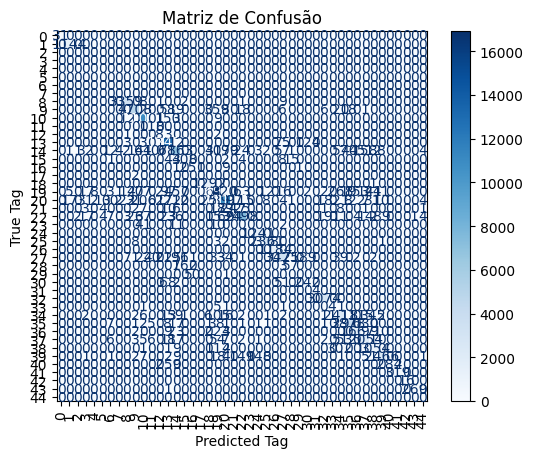

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Gerando a Confusion Matrix (Matriz de Confusão)
cm = confusion_matrix(df_filtrado["tag"], df_filtrado["predicted_tag"],labels=None)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation=90, cmap='Blues')
plt.xlabel('Predicted Tag')
plt.ylabel('True Tag')
plt.title('Matriz de Confusão')
plt.show()

# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=df_test["tag"].unique(), yticklabels=df_test["tag"].unique())
# plt.xlabel("Predicted Tag")
# plt.ylabel("True Tag")
# plt.title("Confusion Matrix")
# plt.show()



## Usando métrica de avaliação com Evalb

Preparando o Predict Label para uso do Evalb

In [ ]:
df_predict_unigram

In [ ]:
df_predict[['word','tag']]

In [ ]:
df_predict_unigram

words_predict_unigram = df_predict['word'].tolist()
tags_predict_unigram = df_predict['tag'].tolist()

predict_label_evalb = list(zip(words_predict_unigram,tags_predict_unigram))

In [ ]:
predict_label_evalb[0]

('The', 'DT')

Construindo as frases do Test Set

In [ ]:
df_predict[['word','tag']]['word']

In [ ]:
# Reconstruindo as frases
def reconstroi_frases(df):
  sentence_predict = []
  text_sentences_predict = []

  lista_word_tag_predict = list(df[['word', 'tag']].itertuples(index=False, name=None))

  for (word,tag) in lista_word_tag_predict:
    if word=='.': #Aqui é a palavra que deve ter pontuação!! (Gold Label) n a tag (que é incerto)
      sentence_predict.append((word,tag))
      text_sentences_predict.append(sentence_predict)
      sentence_predict = []
    else:
      sentence_predict.append((word,tag))
  return text_sentences_predict

In [ ]:
text_sentences_predict = reconstroi_frases(df_predict)

In [ ]:
len(text_sentences_predict)

5395

Aplico o Predict_Label no Evalb

In [ ]:
with open("pred.pos", "w", encoding="utf-8") as f:
    for sent in text_sentences_predict:
        f.write(format_lisp_tree(sent) + "\n")

In [ ]:
!wc -l pred.pos

5395 pred.pos


Tranformando o testset em modelo evalb

In [ ]:
test_set = "/content/drive/MyDrive/O LIVRO/Penn Treebank/Penn Treebank/Secs19-21 - development" #Ju

In [ ]:
content_test_set = []
with open(test_set,'r') as r:
    for line in r:
        parts = line.strip().split()
        pt = [tuple(item.rsplit('_', 1)) for item in parts]
        content_test_set.extend(pt)

words = [word[0] for word in content_test_set]

In [ ]:
df_test = pd.DataFrame(columns=["word", "tag"])

In [ ]:
df_test["word"] = [word[0] for word in content_test_set]
df_test["tag"] = [word[1] for word in content_test_set]

In [ ]:
df_test

In [ ]:
text_sentences_test_set = reconstroi_frases(df_test)

In [ ]:
len(text_sentences_test_set)

In [ ]:
with open("gold.pos", "w", encoding="utf-8") as f:
    for sent in text_sentences_test_set:
        f.write(format_lisp_tree(sent) + "\n")

In [ ]:
!wc -l gold.pos

5395 gold.pos


## Avaliação com Evalb: Gold Label (test set) VS predict label (nosso modelo unigram)

In [ ]:
evalb_path = "/content/drive/MyDrive/EVALB/EVALB/"
!cd /content/drive/MyDrive/EVALB/EVALB/

In [ ]:
cd /content/drive/MyDrive/EVALB/EVALB/

/content/drive/MyDrive/EVALB/EVALB


In [ ]:
ls

bug/         evalb*   LICENSE   new.prm  resultado.txt  tgrep_proc.prl
COLLINS.prm  evalb.c  Makefile  README   sample/


In [ ]:
!chmod +x evalb

In [ ]:
cd /content/

/content


In [ ]:
import subprocess

subprocess.run([evalb_path+"./evalb", "gold.pos", "pred.pos"], stdout=open("/content/res_evalb.txt", "w"))

CompletedProcess(args=['/content/drive/MyDrive/EVALB/EVALB/./evalb', 'gold.pos', 'pred.pos'], returncode=0)

In [ ]:
!wc -l gold.pos
!wc -l pred.pos

5395 gold.pos
5395 pred.pos


In [ ]:
!head gold.pos

(S (DT The) (NNP Arizona) (NNP Corporations) (NNP Commission) (VBD authorized) (DT an) (CD 11.5) (NN %) (NN rate) (NN increase) (IN at) (NNP Tucson) (NNP Electric) (NNP Power) (NNP Co.) (, ,) (RB substantially) (JJR lower) (IN than) (VBN recommended) (JJ last) (NN month) (IN by) (DT a) (NN commission) (NN hearing) (NN officer) (CC and) (RB barely) (PDT half) (DT the) (NN rise) (VBN sought) (IN by) (DT the) (NN utility) (. .))
(S (DT The) (NN ruling) (VBZ follows) (DT a) (NN host) (IN of) (NNS problems) (IN at) (NNP Tucson) (NNP Electric) (, ,) (VBG including) (JJ major) (NNS write-downs) (, ,) (DT a) (CD 60) (NN %) (NN slash) (IN in) (DT the) (JJ common) (NN stock) (NN dividend) (CC and) (DT the) (NN departure) (IN of) (JJ former) (NNP Chairman) (NNP Einar) (NNP Greve) (IN during) (DT a) (NN company) (NN investigation) (IN of) (PRP$ his) (NN stock) (NNS sales) (. .))
(S (DT The) (NNP Arizona) (JJ regulatory) (NN ruling) (VBZ calls) (IN for) ($ $) (CD 42) (CD million) (IN in) (JJ added)

In [ ]:
# prompt: download res_evalb.txt with python

from google.colab import files

files.download('/content/res_evalb.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>